## Использование предобученных моделей

In [1]:
import mediapipe as mp
import matplotlib.pyplot as plt
import cv2 as cv
import time
import dataclasses
import os
import ipywidgets as widgets

from pathlib import Path

from hse_slr.models.utils import SLInference, make_prediction
from hse_slr.draw_landmarks import draw_landmarks_on_image

### Извлечение признаков

Использование моделей из mediapipe для извлечения признаков на основе видео.

Процесс:
1. Создает цикл для чтения кадров из видео
2. Внутри цикла с каждого кадра происходит применение предобученной модели
3. Признаки сохраняются в словарь, а далее их можно сохранить в json

Модели:
1. [HandLandmarker](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker)
2. [PoseLandmarker](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker)

### Извлечение признаков рук

![Точки на руках](images/hand-landmarks.png)

Всего извлекается 21 точка, по 4 точки на каждый палецб и одна точка, показывающая начало запястья

### Настройка модели

In [2]:
data_path = Path(os.getcwd()).parent / 'data'
model_path = data_path / 'hand_landmarker.task'

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
HandLandmarkerResult = mp.tasks.vision.HandLandmarkerResult
VisionRunningMode = mp.tasks.vision.RunningMode

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=2,
    min_hand_detection_confidence = 0.1,
    min_hand_presence_confidence = 0.1,
    min_tracking_confidence = 0.1
)

### Извелечение признаков

In [3]:
cap = cv.VideoCapture(str(data_path / 'raw' / 'train' / '0a04c0f6-48e0-43d5-9e64-d106441cab9e.mp4'))
frames = []

with HandLandmarker.create_from_options(options) as landmarker:

    hand_landmarker_results = []

    while True:

        ret, frame = cap.read()

        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        hand_landmarker_result = landmarker.detect_for_video(mp_image, int(time.time() * 1000))

        frames.append(mp_image)
        hand_landmarker_results.append(dataclasses.asdict(hand_landmarker_result))

    cap.release()

I0000 00:00:1709581094.488610       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Can't receive frame (stream end?). Exiting ...


### Визуализация разметки рук

In [4]:
def show_hands_landmarks(frame=0):
    plt.imshow(
        cv.cvtColor(
            draw_landmarks_on_image(
                frames[frame].numpy_view(),
                hand_landmarker_results[frame],
                landmark_type='hand'
            ),
            cv.COLOR_BGR2RGB)
    )

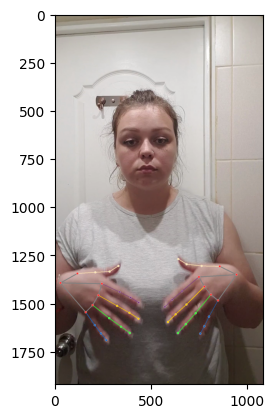

In [14]:
show_hands_landmarks(0)

In [5]:
widgets.interact(
    show_hands_landmarks,
    frame=(0, len(hand_landmarker_results) - 1, 1)
);

interactive(children=(IntSlider(value=0, description='frame', max=47), Output()), _dom_classes=('widget-intera…

### Извлечение признаков поз

<div>
<img src="images/pose_landmarks_index.png" width="350"/>
</div>

Всего извлекается 32 точки: 
* 11 точек с лица
* 12 точек с рук - по 6 с каждой: плечи, локти, запястья, и кисти
* 10 точек с ног - по 5 с каждой: бедра, колени, лодыжки и стопы

[Полный список с названиями](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#pose_landmarker_model)

### Настройка модели

In [6]:
data_path = Path(os.getcwd()).parent / 'data'
model_path = data_path / 'pose_landmarker_heavy.task'

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    num_poses = 1,
    running_mode=VisionRunningMode.VIDEO,
    min_pose_detection_confidence = 0.3,
    min_tracking_confidence = 0.3
)

### Извлечение признаков

In [7]:
cap = cv.VideoCapture(str(data_path / 'raw' / 'train' / '0a04c0f6-48e0-43d5-9e64-d106441cab9e.mp4'))
frames = []

with PoseLandmarker.create_from_options(options) as landmarker:

    pose_landmarker_results = []

    while True:

        ret, frame = cap.read()

        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        pose_landmarker_result = landmarker.detect_for_video(mp_image, int(time.time() * 1000))

        frames.append(mp_image)
        pose_landmarker_results.append(dataclasses.asdict(pose_landmarker_result))

    cap.release()

I0000 00:00:1709581095.914157       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro


Can't receive frame (stream end?). Exiting ...


### Визуализация разметки позы

In [8]:
def show_pose_landmarks(frame=0):
    plt.imshow(
        cv.cvtColor(
            draw_landmarks_on_image(
                frames[frame].numpy_view(),
                pose_landmarker_results[frame],
                landmark_type='pose'
            ),
            cv.COLOR_BGR2RGB)
    )

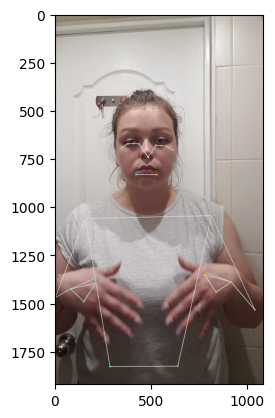

In [13]:
show_pose_landmarks(0)

In [9]:
widgets.interact(
    show_pose_landmarks,
    frame=(0, len(pose_landmarker_results) - 1, 1)
);

interactive(children=(IntSlider(value=0, description='frame', max=47), Output()), _dom_classes=('widget-intera…

### Классификация жестов

Использование предобученной модели [EasySign](https://github.com/ai-forever/easy_sign/tree/main) для распознования РЖЯ

### Настройка модели

In [10]:
CONFIG_PATH = Path(os.getcwd()).absolute().parent / 'hse_slr/models/configs/config.json'

inference_thread = SLInference(CONFIG_PATH)
inference_thread.start()

### Использование модели

In [11]:
res = make_prediction(
    inference_thread,
    str(data_path / 'raw' / 'test' / '0a4da017-349b-4457-9f2a-930978ff5950.mp4')
)

Завершение чтения видео.


In [12]:
print(f'Результат классификации: {res}')

Результат классификации: привет 


## Итоги
1. Посмотрели работу предобученных моделей для извлечения признаков. Далее эти признаки можно использовать для улучшения качества классификатора РЖЯ.
2. Посмотрели работу предобученной модель EasySign для классификации РЖЯ.

На текущий момент можно использовать эти модели для реализации MVP сервиса распознавания РЖЯ.